<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3  </H3>

<H3 align='center'> Rolando Casanueva  </H3>
<H3 align='center'> Gabriel Araya  </H3>
<hr style="height:2px;border:none"/>

In [1]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

In [2]:
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

In [3]:
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

El dataset consiste en 1461 registros del clima de ciudad de Delhi en India, desde 1 de Enero del 2013 hasta el 24 de Abril del 2017. Los 4 parámetros principales son la temperatura promedio del día "meantemp", la humedad "humidity", la velocidad del viento "wind_speed" y la presión promedio "meanpressure", donde la temperatura promedio será el valor a intentar predecir.

meantemp: promedio de las temperaturas obtenidas en intervalos de 3 horas en un día.

humidity: humedad del día medida en gramos de vapor de agua por metro cúbico de volumen de aire.

wind_speed: velocidad del viento medida en kmph (kilómetros por hora).

meanpressure: presión leída del clima medida en atm (atomósferas).

Además, dependiendo de la fecha, se generaron atributos para el tipo de día de la semana (lunes, martes, etc), mes, año y el tipo de estación. Esto nos da un total de 11 atributos.


In [4]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,5,2013,1,0,0,0,1


> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?

In [5]:
#Árbol no regularizado:
from sklearn.tree import DecisionTreeRegressor as Arbol
model_noreg = Arbol()
model_noreg.fit(X_train,y_train)
val_acc = model_noreg.score(X_val,y_val)
print("Accuracy del Árbol no regularizado: {}".format(val_acc))

Accuracy del Árbol no regularizado: 0.8738606575300465


In [6]:
#Árbol regularizado:
from ipywidgets import interactive
def training_regularizado(depth,sample,atrib):
    model_reg = Arbol() 
    model_reg.set_params(max_depth=depth,criterion='mse',splitter='best',min_samples_split=2*sample,max_features=atrib)
    model_reg.fit(X_train,y_train)
    val_acc = model_reg.score(X_val,y_val)
    print("Accuracy del Árbol no regularizado: {}".format(val_acc))

d_min = 1 #define your range
d_max = 50 #sqrt(1468) = 38 aprox
sample_min = 1
sample_min_max = 25
features_min=1
features_max=X_train.shape[1]
interactive(training_regularizado,depth=(d_min,d_max),sample=(sample_min,sample_min_max),atrib=(features_min,features_max))

interactive(children=(IntSlider(value=25, description='depth', max=50, min=1), IntSlider(value=13, description…

Con una profundidad de 32, un split de 38 y 9 atributos se obtuvo un accuracy de 93,6% aprox.

La principal ventaja del árbol de decisión con respecto a los otros modelos escalados, es que si hacemos un grafo del árbol es evidente cuáles fueron los procesos que llevaron a predecir cierto resultado, no es una "caja negra", y es por eso mismo que es evidente determinar cuáles son los atributos más importantes ya que la misma construcción del árbol requiere determinar eso.

No es necesario escalar los datos ya que los árboles no cambiarían su decisión, debido a que los umbrales T de decisión (menor igual, etc) también cambiarían sus valores y por ende el resultado se mantiene, pero se pierde la ventaja de visualización descrita anteriormente.

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.

In [7]:
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )

RMSE train=  1.4144750739446939
RMSE val=  1.856103690387443


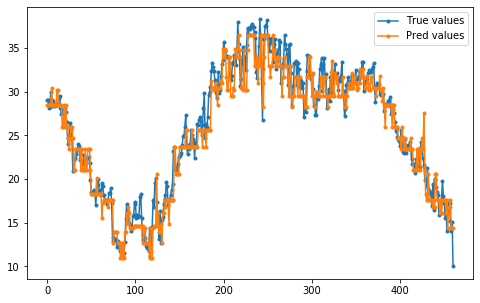

In [10]:
#Árbol regularizado
model_reg = Arbol() 
model_reg.set_params(max_depth=32,criterion='mse',splitter='best',min_samples_split=2*19,max_features=9)
model_reg.fit(X_train,y_train)
y_train_hat = model_reg.predict(X_train)
y_val_hat = model_reg.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

RMSE train=  0.0
RMSE val=  2.409841841184605


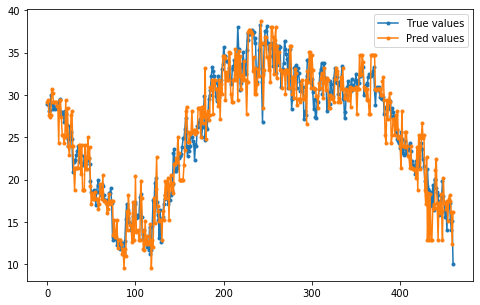

In [11]:
#Árbol no regularizado
model_noreg = Arbol() 
model_noreg.fit(X_train,y_train)
y_train_hat = model_noreg.predict(X_train)
y_val_hat = model_noreg.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

Utilizando los mejores parámetros obtenidos del ejercicio anterior para el árbol regularizado se obtuvo un RMSE en el conjunto de validación de 1.85, en cambio en el árbol no regularizado se obtuvo un RMSE en el conjunto de validación de 2.41.

Cabe señalarse que el árbol no regularizado presentó un RMSE en el conjunto de entrenamiento con valor 0. Tal precisión lleva a pensar que el modelo está demasiado ajustado, es decir, presenta un gran over fitting. Lo cual se corrobora al tener un RMSE de validación mayor que el del árbol regularizado.

El árbol regularizado, a través de sus parámetros óptimos, logra evitar ese sobre ajuste y por eso el RMSE de validación es menor.

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [14]:
%%time
from sklearn.ensemble import BaggingRegressor as Bag
MAX_MODELS = 100 #cantidad de bosques
RMSE_noreg_train = []
RMSE_noreg_val = []
RMSE_reg_train = []
RMSE_reg_val = []
for size in range(1,MAX_MODELS+1): #i votantes en cada iteración, 100 bosques en total
    #árboles no regularizados
    base_learner = Arbol()
    model_i_noreg = Bag(base_estimator=base_learner, n_estimators=size, n_jobs=-1)
    model_i_noreg.fit(X_train,y_train)
    pred_noreg_train = model_i_noreg.predict(X_train)
    pred_noreg_val = model_i_noreg.predict(X_val)
    RMSE_noreg_train.append(RMSE(pred_noreg_train,y_train))
    RMSE_noreg_val.append(RMSE(pred_noreg_val,y_val))
    
    #árboles regularizados
    base_learner.set_params(max_depth=32,criterion='mse',splitter='best',min_samples_split=2*19,max_features=9)
    model_i_reg = Bag(base_estimator=base_learner, n_estimators=size, n_jobs=-1)
    model_i_reg.fit(X_train,y_train)
    pred_reg_train = model_i_reg.predict(X_train)
    pred_reg_val = model_i_reg.predict(X_val)
    RMSE_reg_train.append(RMSE(pred_reg_train,y_train))
    RMSE_reg_val.append(RMSE(pred_reg_val,y_val))

Wall time: 32.5 s


Según lo enseñado en clases, los ensambles se benefician de modelos con overfitting, por lo que el árbol no regularizado debiese tener una disminución de los errores a medida que aumentan los votantes ya que éste presentó un mayor sobreajuste en las pruebas anteriores.

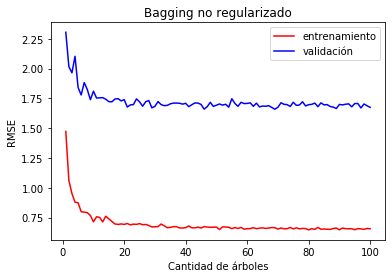

In [15]:
import matplotlib.pyplot as plt
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,RMSE_noreg_train,"red",label="entrenamiento")
plt.plot(iteracion,RMSE_noreg_val,"blue",label="validación")
plt.title("Bagging no regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("RMSE")
plt.legend()
plt.show()

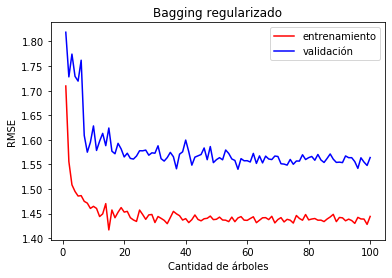

In [16]:
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,RMSE_reg_train,"red",label="entrenamiento")
plt.plot(iteracion,RMSE_reg_val,"blue",label="validación")
plt.title("Bagging regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [17]:
def getmin(vector):
    min = 10000000
    for i in range(len(vector)):
        if vector[i] < min:
            min = vector[i]
            votantes = i+1 #ya que parte de 0
    return (min,votantes)

In [18]:
minimo,votantes = getmin(RMSE_noreg_train)
print("Mínimo RMSE de entrenamiento no regularizado: {} para {} votantes. \n".format(minimo, votantes))
minimo,votantes = getmin(RMSE_noreg_val)
print("Mínimo RMSE de validación no regularizado: {} para {} votantes. \n".format(minimo,votantes))
minimo,votantes = getmin(RMSE_reg_train)
print("Mínimo RMSE de entrenamiento regularizado: {} para {} votantes. \n".format(minimo,votantes))
minimo,votantes = getmin(RMSE_reg_val)
print("Mínimo RMSE de validación regularizado de {} para {} votantes. \n".format(minimo,votantes))

Mínimo RMSE de entrenamiento no regularizado: 0.6471743513830172 para 80 votantes. 

Mínimo RMSE de validación no regularizado: 1.6596442726994525 para 69 votantes. 

Mínimo RMSE de entrenamiento regularizado: 1.4167361191687071 para 15 votantes. 

Mínimo RMSE de validación regularizado de 1.5401032639979877 para 57 votantes. 



Este caso representa una excepción, ya que, anecdóticamente, no se visualiza overfitting. Si hubiera, en el caso del conjunto de entrenamiento se hubiera observado al ERMS no regularizado converger en cero, pero en cambio lo hizo en 0.65 aprox.

Además, en el conjunto de validación el ERMS del Bagging regularizado 1.54 mostró ser menor que el del no regularizado 1.66, por lo que el Bagging regularizado con 57 votantes (n_estimators) es un mejor modelo para este caso. 

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

In [19]:
%%time
from sklearn.ensemble import AdaBoostRegressor as Ada
MAX_MODELS = 100 #cantidad de bosques
RMSE_noreg_train = []
RMSE_noreg_val = []
RMSE_reg_train = []
RMSE_reg_val = []
for size in range(1,MAX_MODELS+1): #i votantes en cada iteración, 100 bosques en total
    base_learner = Arbol()
    model_i_noreg = Ada(base_estimator=base_learner, n_estimators=size)
    model_i_noreg.fit(X_train,y_train)
    pred_noreg_train = model_i_noreg.predict(X_train)
    pred_noreg_val = model_i_noreg.predict(X_val)
    RMSE_noreg_train.append(RMSE(pred_noreg_train,y_train))
    RMSE_noreg_val.append(RMSE(pred_noreg_val,y_val))
    
    
    base_learner.set_params(max_depth=32,criterion='mse',splitter='best',min_samples_split=2*19,max_features=9)
    model_i_reg = Ada(base_estimator=base_learner, n_estimators=size)
    model_i_reg.fit(X_train,y_train)
    pred_reg_train = model_i_reg.predict(X_train)
    pred_reg_val = model_i_reg.predict(X_val)
    RMSE_reg_train.append(RMSE(pred_reg_train,y_train))
    RMSE_reg_val.append(RMSE(pred_reg_val,y_val))

Wall time: 50.8 s


A diferencia de Bagging, Boosting tiene posibilidad de tener overfitting, por lo que se usan base learners regularizados para disminuir el error.

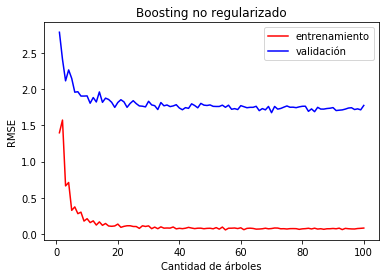

In [20]:
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,RMSE_noreg_train,"red",label="entrenamiento")
plt.plot(iteracion,RMSE_noreg_val,"blue",label="validación")
plt.title("Boosting no regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("RMSE")
plt.legend()
plt.show()

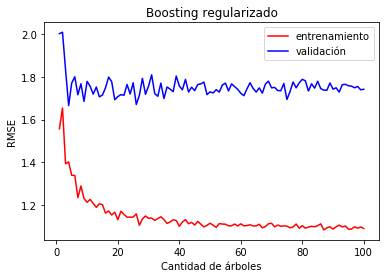

In [21]:
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,RMSE_reg_train,"red",label="entrenamiento")
plt.plot(iteracion,RMSE_reg_val,"blue",label="validación")
plt.title("Boosting regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [22]:
minimo,votantes = getmin(RMSE_noreg_train)
print("Mínimo RMSE de entrenamiento no regularizado: {} para {} votantes. \n".format(minimo, votantes))
minimo,votantes = getmin(RMSE_noreg_val)
print("Mínimo RMSE de validación no regularizado: {} para {} votantes. \n".format(minimo,votantes))
minimo,votantes = getmin(RMSE_reg_train)
print("Mínimo RMSE de entrenamiento regularizado: {} para {} votantes. \n".format(minimo,votantes))
minimo,votantes = getmin(RMSE_reg_val)
print("Mínimo RMSE de validación regularizado de {} para {} votantes. \n".format(minimo,votantes))

Mínimo RMSE de entrenamiento no regularizado: 0.05506578471481636 para 55 votantes. 

Mínimo RMSE de validación no regularizado: 1.6757799233083297 para 70 votantes. 

Mínimo RMSE de entrenamiento regularizado: 1.0827903912362504 para 87 votantes. 

Mínimo RMSE de validación regularizado de 1.6656558248839628 para 4 votantes. 



Esta vez, a diferencia de Bagging, el ERMS no regularizado del conjunto de entrenamiento converge a valores cercanos a cero, siendo el mínimo 0.06 apróx. Por lo que se observa que el boosting no regularizado presenta overfitting.

La otra gran diferencia es que esta vez sí se cumple lo teórico, ya que en el conjunto de validación el ERMS regularizado 1.666 mostró ser menor que el del boosting no regularizado 1.676, pero levemente. Por lo cual se concluye que para este dataset en específico el boosting con árboles regularizados de 4 votantes es mejor.

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [23]:
%%time
from sklearn.ensemble import RandomForestRegressor as RanFor
MAX_MODELS = 100 #cantidad de bosques
RMSE_noreg_train = []
RMSE_noreg_val = []
RMSE_reg_train = []
RMSE_reg_val = []
for size in range(1,MAX_MODELS+1): #i votantes en cada iteración, 100 bosques en total
    model_i_noreg = RanFor(n_estimators=size, n_jobs=-1)
    model_i_noreg.fit(X_train,y_train)
    pred_noreg_train = model_i_noreg.predict(X_train)
    pred_noreg_val = model_i_noreg.predict(X_val)
    RMSE_noreg_train.append(RMSE(pred_noreg_train,y_train))
    RMSE_noreg_val.append(RMSE(pred_noreg_val,y_val))
    
    
    model_i_reg = RanFor(n_estimators=size,max_depth=32,criterion='mse',min_samples_split=2*19,max_features=9, n_jobs=-1)
    model_i_reg.fit(X_train,y_train)
    pred_reg_train = model_i_reg.predict(X_train)
    pred_reg_val = model_i_reg.predict(X_val)
    RMSE_reg_train.append(RMSE(pred_reg_train,y_train))
    RMSE_reg_val.append(RMSE(pred_reg_val,y_val))

Wall time: 1min 7s


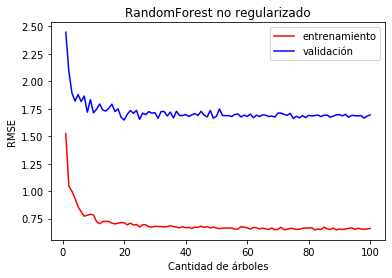

In [24]:
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,RMSE_noreg_train,"red",label="entrenamiento")
plt.plot(iteracion,RMSE_noreg_val,"blue",label="validación")
plt.title("RandomForest no regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("RMSE")
plt.legend()
plt.show()

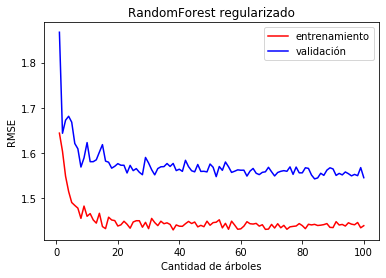

In [25]:
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,RMSE_reg_train,"red",label="entrenamiento")
plt.plot(iteracion,RMSE_reg_val,"blue",label="validación")
plt.title("RandomForest regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [26]:
minimo,votantes = getmin(RMSE_noreg_train)
print("Mínimo RMSE de entrenamiento no regularizado: {} para {} votantes. \n".format(minimo, votantes))
minimo,votantes = getmin(RMSE_noreg_val)
print("Mínimo RMSE de validación no regularizado: {} para {} votantes. \n".format(minimo,votantes))
minimo,votantes = getmin(RMSE_reg_train)
print("Mínimo RMSE de entrenamiento regularizado: {} para {} votantes. \n".format(minimo,votantes))
minimo,votantes = getmin(RMSE_reg_val)
print("Mínimo RMSE de validación regularizado de {} para {} votantes. \n".format(minimo,votantes))

Mínimo RMSE de entrenamiento no regularizado: 0.6463449596871864 para 89 votantes. 

Mínimo RMSE de validación no regularizado: 1.6475490180950056 para 20 votantes. 

Mínimo RMSE de entrenamiento regularizado: 1.428593175552578 para 38 votantes. 

Mínimo RMSE de validación regularizado de 1.5418959992268768 para 84 votantes. 



No se aprecia overfitting en los conjuntos de entrenamiento de ninguno de los dos casos, y de igual forma que Bagging, RandomForest no regularizado presentó un peor ERMS de validación que el regularizado.

El comportamiento de RandomForest es muy similar al de Bagging, siendo para este caso particular Bagging un poquito mejor. Lo anterior se contradice al caso general, en el que RandomForest es mejor que Bagging debido a su mayor independencia entre los árboles con la muestra trabajada.

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).

Los métodos de Bagging y RandomForest emplean boostrap y presentan el parámetro oob_score.

In [27]:
%%time
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingRegressor as Bag
MAX_MODELS = 100 #cantidad de bosques
score_noreg_val = []
score_reg_val = []
oob_noreg = []
oob_reg = []
for size in range(1,MAX_MODELS+1): #i votantes en cada iteración, 100 bosques en total
    #árboles no regularizados
    base_learner = Arbol()
    model_i_noreg = Bag(base_estimator=base_learner, n_estimators=size, n_jobs=-1,oob_score=True)
    model_i_noreg.fit(X_train,y_train)
    pred_noreg_val = model_i_noreg.predict(X_val)
    score_noreg_val.append(model_i_noreg.score(X_val,y_val))
    oob_noreg.append(model_i_noreg.oob_score_)
    
    #árboles regularizados
    base_learner.set_params(max_depth=32,criterion='mse',splitter='best',min_samples_split=2*19,max_features=9)
    model_i_reg = Bag(base_estimator=base_learner, n_estimators=size, n_jobs=-1,oob_score=True)
    model_i_reg.fit(X_train,y_train)
    pred_reg_val = model_i_reg.predict(X_val)
    score_reg_val.append(model_i_reg.score(X_val,y_val))
    oob_reg.append(model_i_reg.oob_score_)

Wall time: 36.6 s


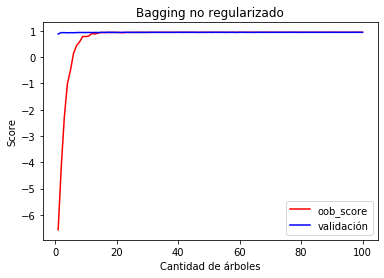

In [28]:
import matplotlib.pyplot as plt
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,oob_noreg,"red",label="oob_score")
plt.plot(iteracion,score_noreg_val,"blue",label="validación")
plt.title("Bagging no regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("Score")
plt.legend()
plt.show()

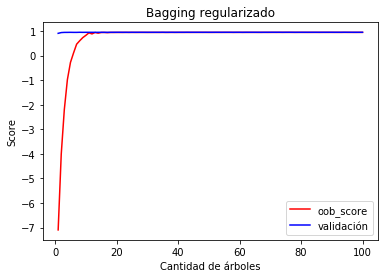

In [29]:
import matplotlib.pyplot as plt
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,oob_reg,"red",label="oob_score")
plt.plot(iteracion,score_reg_val,"blue",label="validación")
plt.title("Bagging regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("Score")
plt.legend()
plt.show()

In [30]:
%%time
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor as RanFor
MAX_MODELS = 100 #cantidad de bosques
score_noreg_val = []
score_reg_val = []
oob_noreg = []
oob_reg = []
for size in range(1,MAX_MODELS+1): #i votantes en cada iteración, 100 bosques en total
    #árboles no regularizados
    base_learner = Arbol()
    model_i_noreg = RanFor(n_estimators=size, n_jobs=-1,oob_score=True)
    model_i_noreg.fit(X_train,y_train)
    pred_noreg_val = model_i_noreg.predict(X_val)
    score_noreg_val.append(model_i_noreg.score(X_val,y_val))
    oob_noreg.append(model_i_noreg.oob_score_)
    
    #árboles regularizados
    model_i_reg = RanFor(n_estimators=size,max_depth=32,criterion='mse',min_samples_split=2*19,max_features=9, n_jobs=-1,oob_score=True)
    model_i_reg.fit(X_train,y_train)
    pred_reg_val = model_i_reg.predict(X_val)
    score_reg_val.append(model_i_reg.score(X_val,y_val))
    oob_reg.append(model_i_reg.oob_score_)

Wall time: 1min 9s


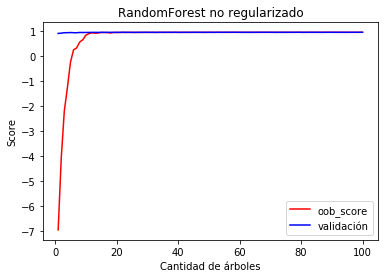

In [31]:
import matplotlib.pyplot as plt
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,oob_noreg,"red",label="oob_score")
plt.plot(iteracion,score_noreg_val,"blue",label="validación")
plt.title("RandomForest no regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("Score")
plt.legend()
plt.show()

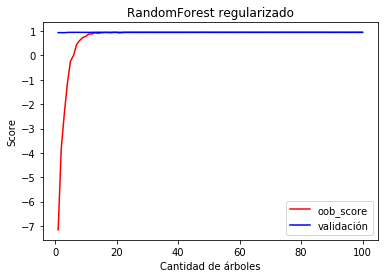

In [32]:
import matplotlib.pyplot as plt
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,oob_reg,"red",label="oob_score")
plt.plot(iteracion,score_reg_val,"blue",label="validación")
plt.title("RandomForest regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("Score")
plt.legend()
plt.show()

Por lo visto en todos los gráficos, oob_score se comporta de forma similar al score siempre y cuanbdo la cantidad de votantes (árboles) no sea menor a 15.
Por lo que cuando se tiene una cantidad pequeña de votantes, oob_score no es una buena métrica de generalización.

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos. 

Se utilizará Bagging al ser el mejor de todos los modelos probados en el conjunto de validación. Y la decisión de combinación será la del primer cuartil (percentil 25).

In [33]:
import numpy as np
def combine_predictions(predictions):
    return np.percentile(predictions,25)

In [34]:
%%time
from sklearn.ensemble import BaggingRegressor as Bag
MAX_MODELS = 100 #cantidad de bosques
RMSE_noreg_train = []
RMSE_noreg_val = []
RMSE_reg_train = []
RMSE_reg_val = []
RMSE_noreg_new =[]
RMSE_reg_new =[]
for size in range(1,MAX_MODELS+1): #i votantes en cada iteración, 100 bosques en total
    #árboles no regularizados
    base_learner = Arbol()
    model_i_noreg = Bag(base_estimator=base_learner, n_estimators=size, n_jobs=-1)
    model_i_noreg.fit(X_train,y_train)
    pred_noreg_train = model_i_noreg.predict(X_train)
    pred_noreg_val = model_i_noreg.predict(X_val)
    RMSE_noreg_train.append(RMSE(pred_noreg_train,y_train))
    RMSE_noreg_val.append(RMSE(pred_noreg_val,y_val))
    list_estimators_noreg = model_i_noreg.estimators_
    list_predictions_noreg = [estimator.predict(X_val) for estimator in list_estimators_noreg]
    new_predictions_noreg = combine_predictions(list_predictions_noreg)
    RMSE_noreg_new.append(RMSE(y_val,new_predictions_noreg))
    
    #árboles regularizados
    base_learner.set_params(max_depth=32,criterion='mse',splitter='best',min_samples_split=2*19,max_features=9)
    model_i_reg = Bag(base_estimator=base_learner, n_estimators=size, n_jobs=-1)
    model_i_reg.fit(X_train,y_train)
    pred_reg_train = model_i_reg.predict(X_train)
    pred_reg_val = model_i_reg.predict(X_val)
    RMSE_reg_train.append(RMSE(pred_reg_train,y_train))
    RMSE_reg_val.append(RMSE(pred_reg_val,y_val))
    list_estimators_reg = model_i_reg.estimators_
    list_predictions_reg = [estimator.predict(X_val) for estimator in list_estimators_reg]
    new_predictions_reg = combine_predictions(list_predictions_reg)
    RMSE_reg_new.append(RMSE(y_val,new_predictions_reg))

Wall time: 34 s


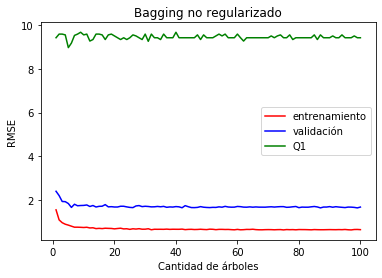

In [35]:
import matplotlib.pyplot as plt
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,RMSE_noreg_train,"red",label="entrenamiento")
plt.plot(iteracion,RMSE_noreg_val,"blue",label="validación")
plt.plot(iteracion,RMSE_noreg_new,"green",label="Q1")
plt.title("Bagging no regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("RMSE")
plt.legend()
plt.show()

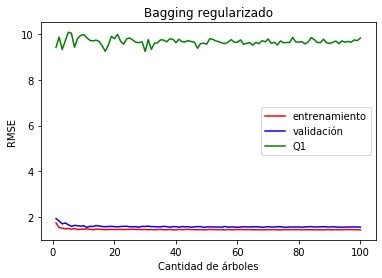

In [36]:
import matplotlib.pyplot as plt
iteracion = []
for i in range(100):
    iteracion.append(i+1)
plt.plot(iteracion,RMSE_reg_train,"red",label="entrenamiento")
plt.plot(iteracion,RMSE_reg_val,"blue",label="validación")
plt.plot(iteracion,RMSE_reg_new,"green",label="Q1")
plt.title("Bagging regularizado")
plt.xlabel("Cantidad de árboles")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Se decidió hacer una comparación con Bagging. De ésta se puede apreciar que tanto para el caso regularizado como el no regularizado, el RMSE del nuevo método de combinación del primer cuartil es 5 veces superior. Es decir, fue una muy mala forma de decidir la regresión utilizando el primer cuartil para este dataset en particular.

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.

In [37]:
T = 150
base_learner = Arbol()
base_learner.set_params(max_depth=32,criterion='mse',splitter='best',min_samples_split=2*19,max_features=9)
model_new = Bag(base_estimator=base_learner, n_estimators=T, n_jobs=-1)
model_new.fit(X_train, y_train)
list_estimators = model_new.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]

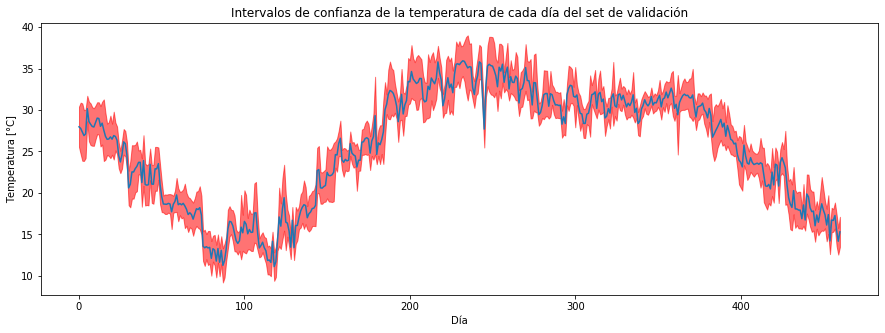

In [38]:
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(15,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.xlabel("Día")
plt.ylabel("Temperatura [°C]")
plt.title("Intervalos de confianza de la temperatura de cada día del set de validación")
plt.show()

Hay zonas donde claramente se ven intervalos con 5 grados de de largo y otras donde casi no hay. Es razonable pensar que sim promediamos todos los intervalos se obtiene un largo aproximado de 3, que sería el doble de los RMSE vistos hasta ahora.

>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.

Como se indicó anteriormente, el mejor modelo fue Bagging regularizado, por lo que se trabajará con él a continuación.

In [39]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTest.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

In [40]:
#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
#any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

In [41]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,y_value,cday,year,month,season_summer,season_winter
0,15.913043,85.869565,2.743478,59.000000,18.500000,6,2017,1,0,1
1,18.500000,77.222222,2.894444,1018.277778,17.111111,0,2017,1,0,1
2,17.111111,81.888889,4.016667,1018.333333,18.700000,1,2017,1,0,1
3,18.700000,70.050000,4.545000,1015.700000,18.388889,2,2017,1,0,1
4,18.388889,74.944444,3.300000,1014.333333,19.318182,3,2017,1,0,1


Las columnas season_fall y season_rainy no se agregaron, por lo que las insertaremos artificalmente.

In [42]:
df['season_fall'] = df.apply(lambda x: 0, axis=1)
df['season_rainy'] = df.apply(lambda x: 0, axis=1)

In [43]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,y_value,cday,year,month,season_summer,season_winter,season_fall,season_rainy
0,15.913043,85.869565,2.743478,59.000000,18.500000,6,2017,1,0,1,0,0
1,18.500000,77.222222,2.894444,1018.277778,17.111111,0,2017,1,0,1,0,0
2,17.111111,81.888889,4.016667,1018.333333,18.700000,1,2017,1,0,1,0,0
3,18.700000,70.050000,4.545000,1015.700000,18.388889,2,2017,1,0,1,0,0
4,18.388889,74.944444,3.300000,1014.333333,19.318182,3,2017,1,0,1,0,0


In [44]:
y_test = df.pop("y_value").values
X_test = df.values

RMSE test=  1.6493581155996824
Accuracy = 0.9322448262549241


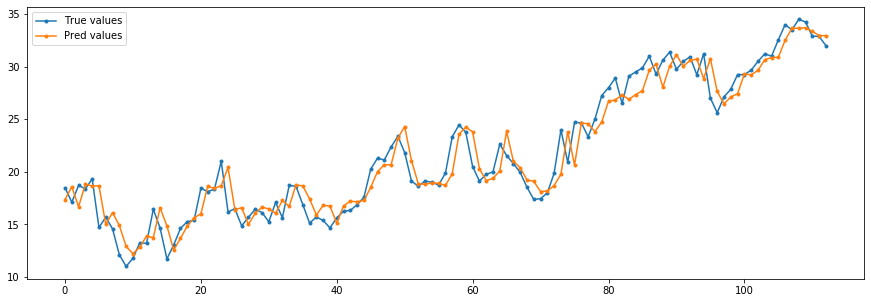

In [48]:
from sklearn.tree import DecisionTreeRegressor as Arbol
from sklearn.ensemble import BaggingRegressor as Bag
n_votantes = 71 #del ejercicio de Bagging regularizado
base_learner = Arbol()
base_learner.set_params(max_depth=32,criterion='mse',splitter='best',min_samples_split=2*19,max_features=9)
model = Bag(base_estimator=base_learner, n_estimators=n_votantes, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
list_estimators = model.estimators_
list_predictions2 = [estimator.predict(X_test) for estimator in list_estimators]
print("RMSE test= ",RMSE(y_test,y_pred))
print("Accuracy =", model.score(X_test,y_test))
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(y_test, '.-' ,label="True values")
plt.plot(y_pred, '.-' ,label="Pred values")
plt.legend()
plt.show()

De todos los metodos, el menos interesante fue AdaBoost, ya que entrego errores de validación más altos para los casos regularizados (1.67) y no regularizados (1.68). Bagging y RandomForest se comportaron de forma muy similar, con errores de validación casi idénticos para los casos regularizado (1.54 y 1.54 respectivamente)  y no regularizado (1.66 y 1.65 respectivamente) siendo para este dataset en específico mejor Baggings tanto en errores como tiempo, ya que RandomForest se demoró 1min07s comparado a los 35s de Bagging.


La métrica del cálculo final para la decisión de cada votante (n_estimator) está en su óptimo como el promedio de las votaciones, ya que se intentó calcularla mediante el cuartil Q1 (y fuera del informe se intentó con la mediana y Q3 también) entregando pésimos errores (casi el quintuple que si se hubiera calculado con la media).

En conclusión, por tiempo de proceso y cálculo del RMSE, Bagging fue un mejor modelo para este dataset del clima de la ciudad de Delhi.